In [9]:
# notebook globals
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import PercentFormatter
#from scipy.stats import norm
from scipy import stats

# get fights data
#df = pd.read_csv('../tuf/fights.csv')
df = pd.read_csv('enhanced_fights.csv') # use enhanced data
all_wins = df[df['outcome'] == "win"].copy()
win_total = len(all_wins)

# get sub data if sub type is given
subs = df[(df['method'] == 'SUB') & (df['method_details'] != 'N/A')].copy()
# make submission type more readable
subs['sub_type'] = subs['method_details'].str.title().str.replace('Naked', 'N.').str.replace('Choke', 'C.')

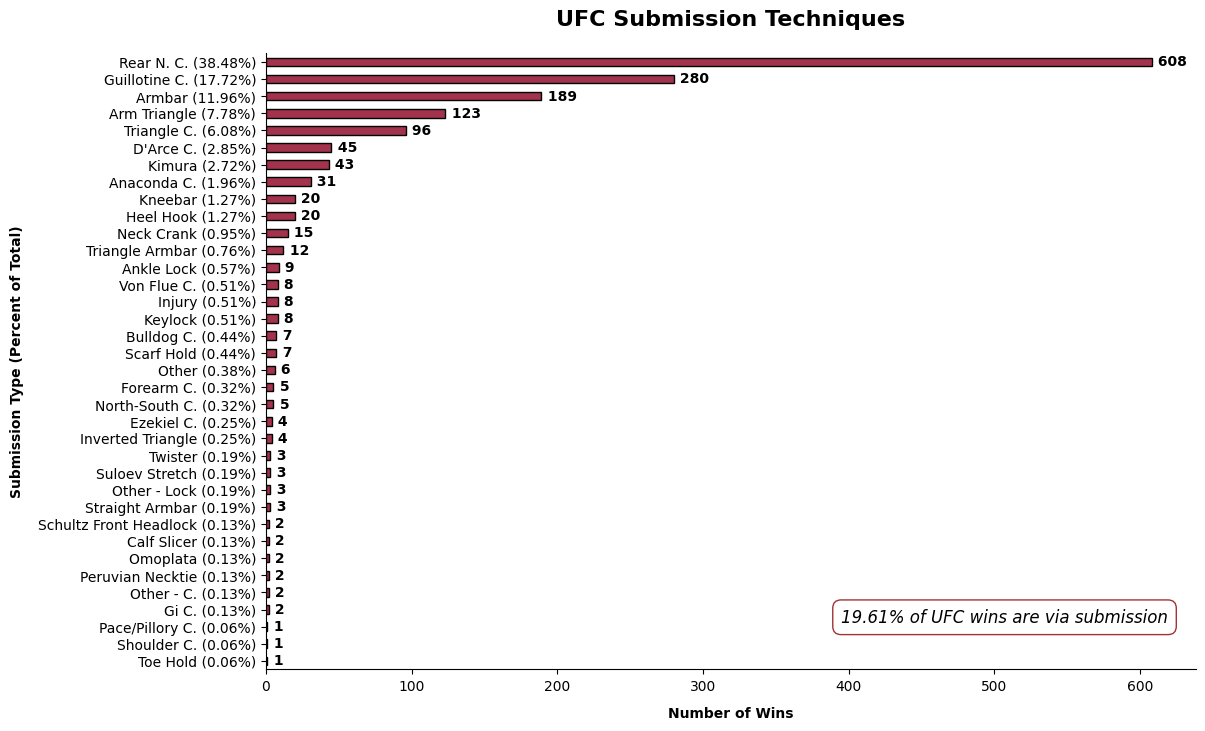

In [10]:
# plot for submission type
plt.figure(figsize=(12, 8))
# get number of wins for each type of submission, sorting by occurance
sub_counts = subs['sub_type'].value_counts().sort_values()
# total submissions in UFC history
sub_total = sub_counts.sum()

# create y label with percent next to submission name
y_labels = [f"{name} ({count/sub_total:.2%})" for name, count in zip(sub_counts.index, sub_counts)]

# populate graph
ax = sub_counts.plot(kind='barh', color='#a3324c', edgecolor='black')
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)

# create title / labels
plt.title('UFC Submission Techniques', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Number of Wins', labelpad=10, fontweight='bold')
plt.ylabel('Submission Type (Percent of Total)', labelpad=10, fontweight='bold')

# raw number of wins for each submission
total = sub_counts.sum()
for i, v in enumerate(sub_counts):
    ax.text(v + 1, i, f" {v}", color='black', va='center', fontsize=10, fontweight='bold')

# add figtext for more context
subtitle = f"{(sub_total/win_total * 100):.2f}% of UFC wins are via submission"
plt.figtext(
    0.97, .07,
    subtitle,
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize=12,
    fontstyle='italic',
    color='black',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='darkred', boxstyle='round,pad=0.5')

)

# plot (not using 'tight_layout' to fully show the disparity)
sns.despine()
plt.show()

<Figure size 1600x900 with 0 Axes>

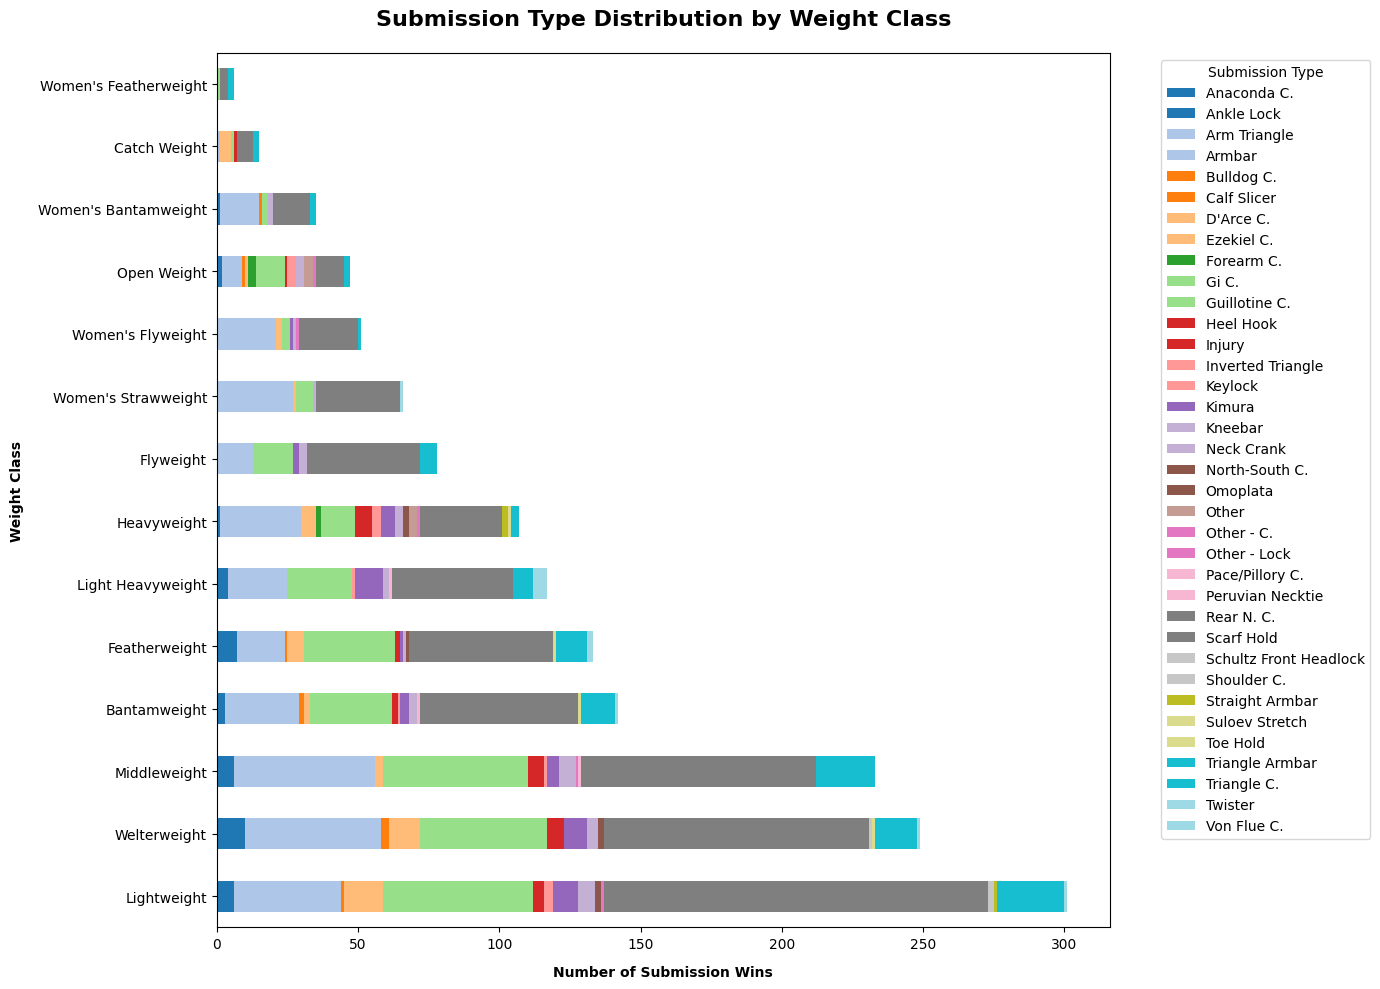

In [11]:
# create stacked bar chart for number of submission wins and type of submission by weightclass
plt.figure(figsize=(16, 9))
# group submission type by weight class
grouped = subs.groupby(['weight_class', 'sub_type']).size().reset_index(name='count')
pivot = grouped.pivot(index='weight_class', columns='sub_type', values='count').fillna(0)

# go from least to most subs
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot.plot(kind='barh', stacked=True, figsize=(14, 10), colormap='tab20')

# create titles / labels
plt.title('Submission Type Distribution by Weight Class', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Number of Submission Wins', labelpad=10, fontweight='bold')
plt.ylabel('Weight Class', labelpad=10, fontweight='bold')
plt.legend(title='Submission Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# plot
plt.tight_layout()
plt.show()

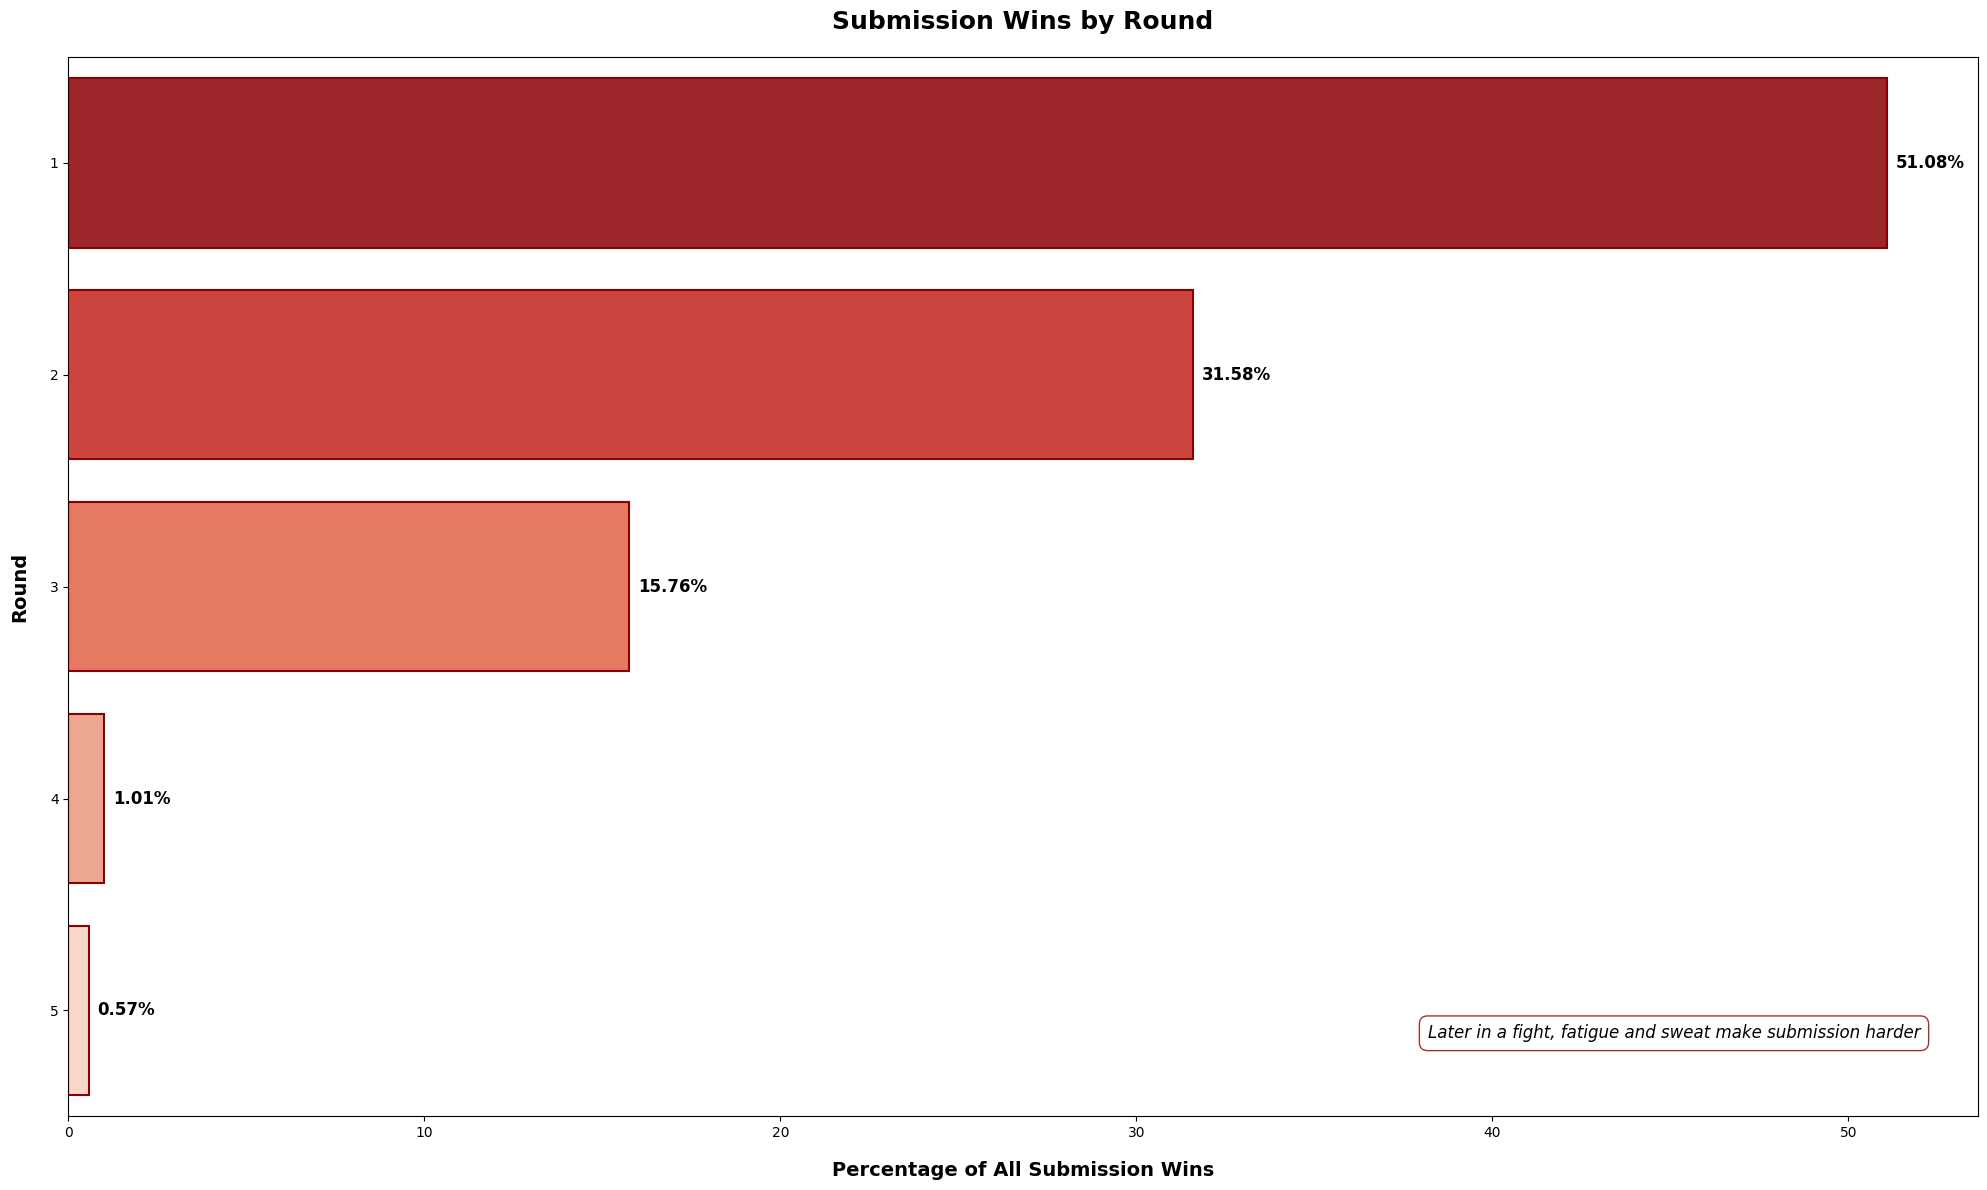

In [12]:
# get round and percentage of total submission wins in that round
round_counts = subs['end_round'].value_counts().sort_index()
round_percentages = (round_counts / round_counts.sum() * 100).round(2)

# create a dataframe for round and percent
plot_data = pd.DataFrame({
    'Round': round_percentages.index,
    'Percentage': round_percentages.values
})

# create color gradient
colors = sns.color_palette("Reds_r", n_colors=len(plot_data))

# create plot
plt.figure(figsize=(20, 12))
ax = sns.barplot(
    x='Percentage',
    y='Round',
    hue='Round',
    palette=colors,
    data=plot_data,
    orient='h',
    edgecolor='darkred',
    linewidth=1.5,
    legend=False
)

# add percent to bars
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(
        width + 0.25,
        p.get_y() + p.get_height()/2,
        f'{width:.2f}%',
        ha='left',
        va='center',
        fontsize=12,
        fontweight='bold'
    )

# create title / labels
plt.title('Submission Wins by Round', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Percentage of All Submission Wins', fontsize=14, labelpad=15, fontweight='bold')
plt.ylabel('Round', fontsize=14, labelpad=15, fontweight='bold')

# add figtext for possible explanation
plt.figtext(
    0.97, .07,
    "Later in a fight, fatigue and sweat make submission harder",
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize=12,
    fontstyle='italic',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='darkred', boxstyle='round,pad=0.5')
)

# plot
plt.tight_layout()
plt.show()

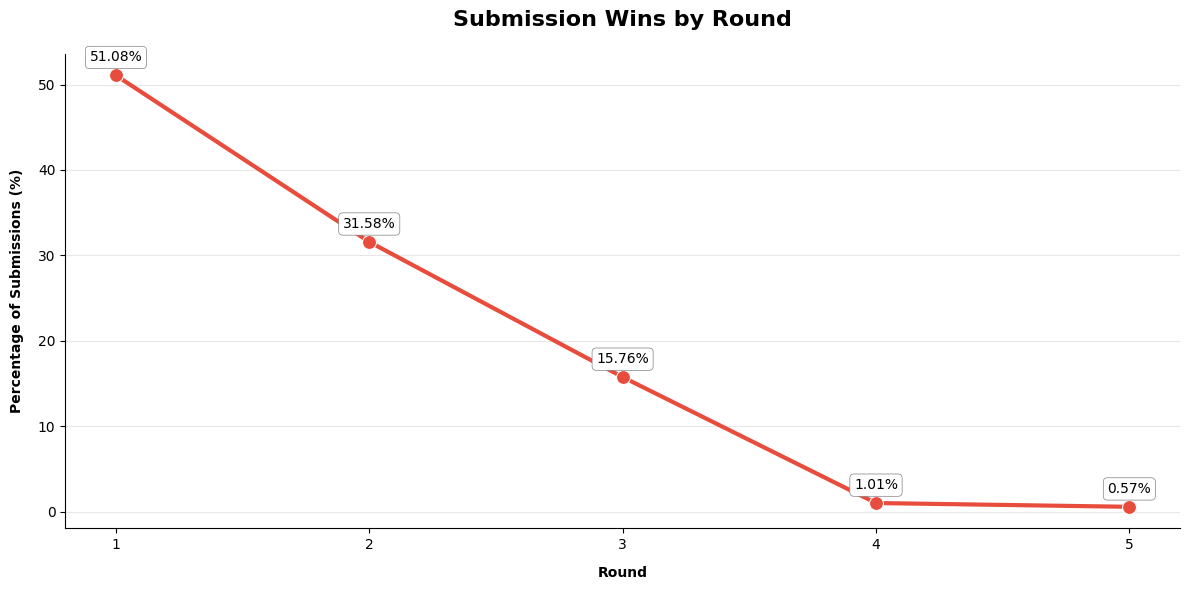

In [13]:
# line plot for which round contained a submission in fights won by submission
plt.figure(figsize=(12, 6))

# find the last round in fights won by submission
round_subs = subs['end_round'].value_counts(normalize=True).sort_index() * 100

# create line plot
ax = sns.lineplot(
    x=round_subs.index, 
    y=round_subs.values,
    marker='o',
    markersize=10,
    linewidth=3,
    color='#e74c3c'
)

# create titles / labels
plt.title('Submission Wins by Round', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Round', labelpad=10, fontweight='bold')
plt.ylabel('Percentage of Submissions (%)', labelpad=10, fontweight='bold')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)

# add percentage on graph
for x, y in zip(round_subs.index, round_subs.values):
    ax.annotate(f'{y:.2f}%', (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5))

# plot
sns.despine()
plt.tight_layout()
plt.show()

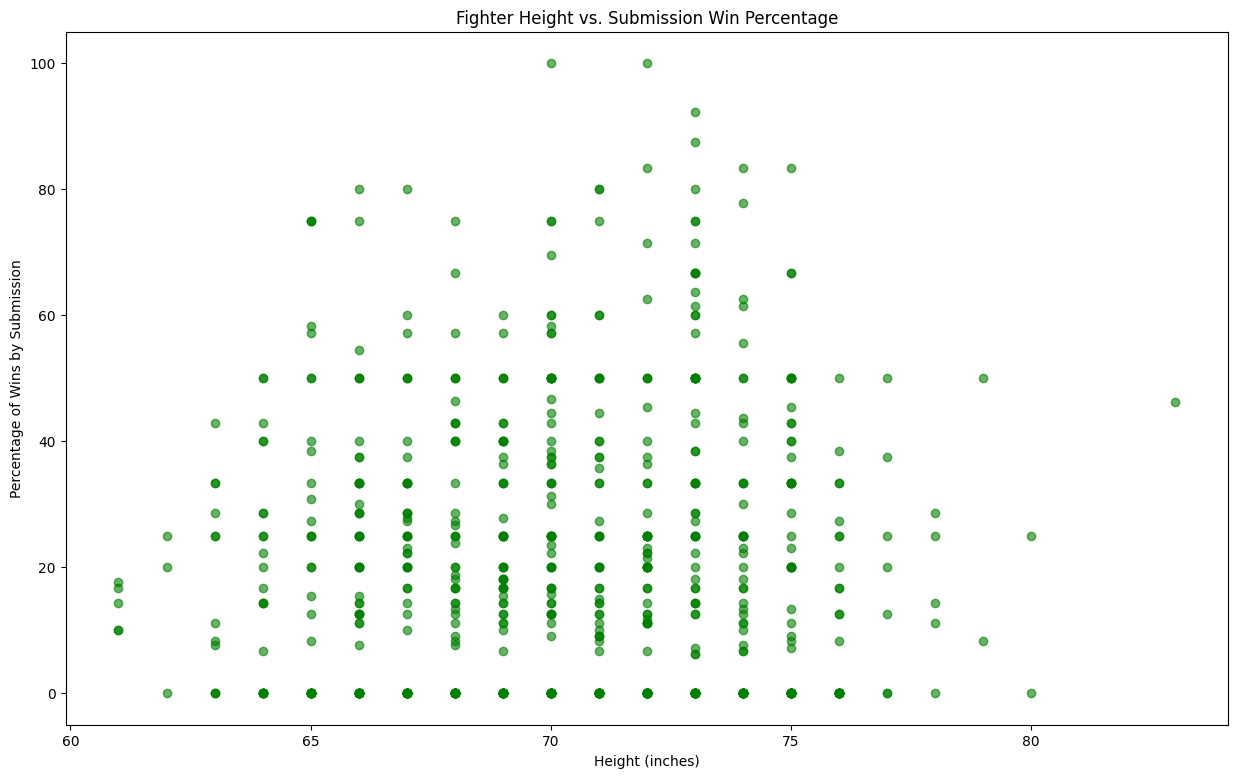

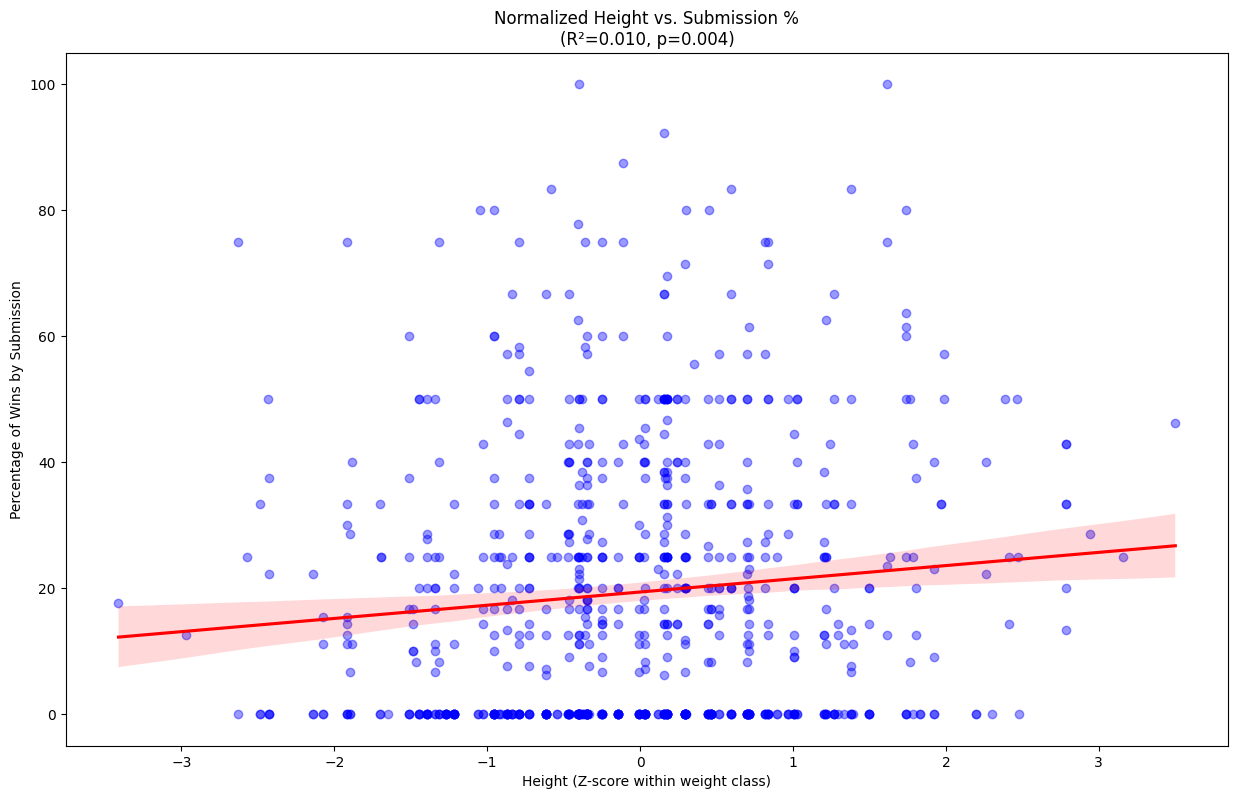

For each positive standard deviation in height (within a weightclass),
the percentage of wins being submissions changes by 2.10 points.


In [14]:
# scatter plot of percent of a fighter's wins being by submission and fighters height
# - one thing that could skew this is that fighters in certain weightclasses have different average heights
# - someone might be a short heavyweight with a lot of submission wins, but appear tall compared to all fighters
#   - to address this I will also plot with heights normalized by weightclass
# - note some fighters have a 100% submission rate usually this means they had one fight and won by submission
#   - to clean the data filtering for at least 3 wins overall

# all fights
fights = df.copy()

# remove fights without height data
fights = fights.dropna(subset=['f1_height', 'f2_height'])

# add heights normalized by weightclass
fights['f1_norm_height'] = fights.groupby('weight_class')['f1_height'].transform(
    lambda x: (x - x.mean()) / x.std()
)
fights['f2_norm_height'] = fights.groupby('weight_class')['f2_height'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# all fighters
all_fighters = pd.concat([fights['f1_name'], fights['f2_name']]).unique()

# list to hold sub data
submission_data = []

for fighter in all_fighters:
    # all wins
    wins = fights[fights['winner'] == fighter]
    total_wins = len(wins)
    
    # filter for fighters with more than 3 wins
    if total_wins > 3:
        # submission wins
        sub_wins = len(wins[wins['method'] == 'SUB'])
        # percent of wins by submission
        sub_percent = (sub_wins / total_wins) * 100
        # height
        fighter_height = wins.iloc[0]['f1_height'] if wins.iloc[0]['f1_name'] == fighter else wins.iloc[0]['f2_height']
        # height normalized by weightclass
        fighter_norm_height = wins.iloc[0]['f1_norm_height'] if wins.iloc[0]['f1_name'] == fighter else wins.iloc[0]['f2_norm_height']

        # add data
        submission_data.append({
            'fighter': fighter,
            'height': fighter_height,
            'norm_height' : fighter_norm_height,
            'sub_percent': sub_percent,
            'total_wins': total_wins
        })

# convert to dataframe
sub_df = pd.DataFrame(submission_data)

# plot for height
plt.figure(figsize=(15, 9))
plt.scatter(sub_df['height'], sub_df['sub_percent'], alpha=0.6, color="green")
plt.title('Fighter Height vs. Submission Win Percentage')
plt.xlabel('Height (inches)')
plt.ylabel('Percentage of Wins by Submission')
plt.show()

# regression values
slope, _, r_value, p_value, _ = stats.linregress(
    sub_df['norm_height'], sub_df['sub_percent']
)

# plot for normalized height
plt.figure(figsize=(15, 9))
plt.title(f"Normalized Height vs. Submission %\n(R²={r_value**2:.3f}, p={p_value:.3f})")
sns.regplot(
    x='norm_height',
    y='sub_percent',
    data=sub_df, 
    scatter_kws={'alpha':0.4, 'color':'blue'}, # scatter plot
    line_kws={'color':'red'} # 
)
plt.xlabel('Height (Z-score within weight class)')
plt.ylabel('Percentage of Wins by Submission')
plt.show()
print(f"For each positive standard deviation in height (within a weightclass),\nthe percentage of wins being submissions changes by {slope:.2f} points.")

1.6958010800222028


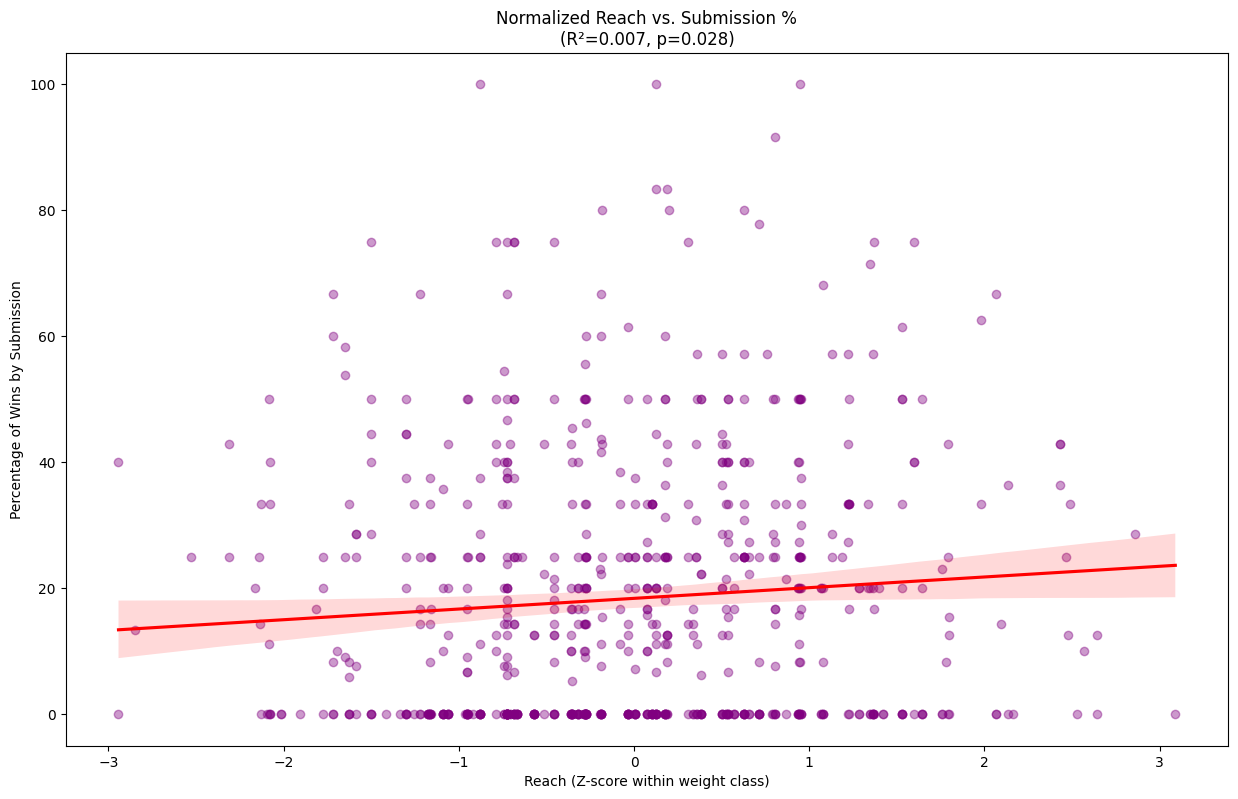

For each positive standard deviation in reach (within a weightclass),
the percentage of wins being submissions changes by 1.69580 points.


In [15]:
# scatter plot of percent of a fighter's wins being by submission and fighters normalized reach for their weight class
# - one thing that could skew this is that fighters can move between weight classes

# all fights
fights = df.copy()

# remove fights without reach data
fights = fights.dropna(subset=['f1_reach','f2_reach'])

# add reach normalized by weightclass
fights['f1_norm_reach'] = fights.groupby('weight_class')['f1_reach'].transform(
    lambda x: (x - x.mean()) / x.std()
)
fights['f2_norm_reach'] = fights.groupby('weight_class')['f2_reach'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# all fighters
all_fighters = pd.concat([fights['f1_name'], fights['f2_name']]).unique()

# list to hold sub data
submission_data = []

for fighter in all_fighters:
    # all wins
    wins = fights[fights['winner'] == fighter]
    total_wins = len(wins)
    
    # filter for fighters with more than 3 wins
    if total_wins > 3:
        # submission wins
        sub_wins = len(wins[wins['method'] == 'SUB'])
        # percent of wins by submission
        sub_percent = (sub_wins / total_wins) * 100
        # height
        fighter_reach = wins.iloc[0]['f1_reach'] if wins.iloc[0]['f1_name'] == fighter else wins.iloc[0]['f2_reach']
        # reach normalized by weightclass
        fighter_norm_reach = wins.iloc[0]['f1_norm_reach'] if wins.iloc[0]['f1_name'] == fighter else wins.iloc[0]['f2_norm_reach']

        # add data
        submission_data.append({
            'fighter': fighter,
            'reach': fighter_reach,
            'norm_reach' : fighter_norm_reach,
            'sub_percent': sub_percent,
            'total_wins': total_wins
        })

# convert to dataframe
sub_df = pd.DataFrame(submission_data)

# regression values
slope, _, r_value, p_value, _ = stats.linregress(
    sub_df['norm_reach'], sub_df['sub_percent']
)
print(slope)
# plot for normalized reach
plt.figure(figsize=(15, 9))
plt.title(f"Normalized Reach vs. Submission %\n(R²={r_value**2:.3f}, p={p_value:.3f})")
sns.regplot(
    x='norm_reach',
    y='sub_percent',
    data=sub_df, 
    scatter_kws={'alpha':0.4, 'color':'purple'}, # scatter plot
    line_kws={'color':'red'} # 
)
plt.xlabel('Reach (Z-score within weight class)')
plt.ylabel('Percentage of Wins by Submission')
plt.show()
print(f"For each positive standard deviation in reach (within a weightclass),\nthe percentage of wins being submissions changes by {slope:.5f} points.")

Final DataFrame length: 2552


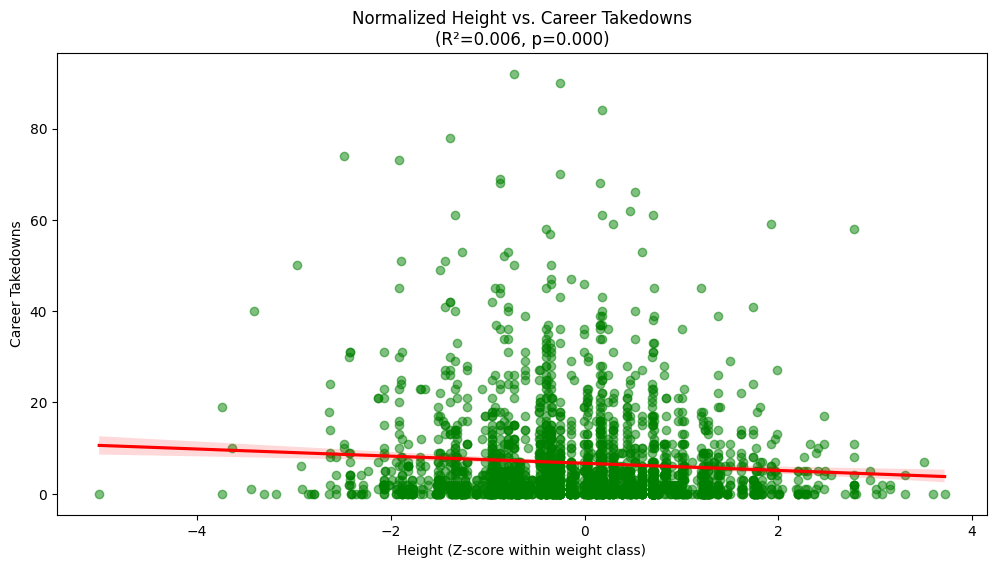

In [47]:
# scatter plot of career takedowns vs. normalized height
fights = df.copy()

# Remove fights without height/takedown data
fights = fights.dropna(subset=['f1_height', 'f2_height', 'f1_td', 'f2_td'])

# Normalize heights by weight class
fights['f1_nh'] = fights.groupby('weight_class')['f1_height'].transform(
    lambda x: (x - x.mean()) / x.std()
)
fights['f2_nh'] = fights.groupby('weight_class')['f2_height'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Calculate career takedowns and normalized height per fighter
takedown_data = []
for fighter in pd.concat([fights['f1_name'], fights['f2_name']]).unique():
    # Takedowns as f1 and f2
    takedowns_f1 = fights[fights['f1_name'] == fighter]['f1_td'].sum()
    takedowns_f2 = fights[fights['f2_name'] == fighter]['f2_td'].sum()
    career_takedowns = takedowns_f1 + takedowns_f2
    
    # get normalized height
    f1_fights = fights[fights['f1_name'] == fighter]
    f2_fights = fights[fights['f2_name'] == fighter]
    fighter_norm_height = f1_fights.iloc[0]['f1_nh'] if len(f1_fights) > 0 else f2_fights.iloc[0]['f2_nh']
    
    takedown_data.append({
        'fighter': fighter,
        'norm_height': fighter_norm_height,
        'career_takedowns': career_takedowns
    })

# Create DataFrame and drop NaN
takedown_df = pd.DataFrame(takedown_data).dropna()
print(f"Final DataFrame length: {len(takedown_df)}")

# Plot and regression
slope, _, r_value, p_value, _ = stats.linregress(
    takedown_df['norm_height'], takedown_df['career_takedowns']
)
plt.figure(figsize=(12, 6))
sns.regplot(
    x='norm_height', 
    y='career_takedowns', 
    data=takedown_df,
    scatter_kws={'alpha': 0.5, 'color': 'green'},
    line_kws={'color': 'red'}
)
plt.title(f"Normalized Height vs. Career Takedowns\n(R²={r_value**2:.3f}, p={p_value:.3f})")
plt.xlabel('Height (Z-score within weight class)')
plt.ylabel('Career Takedowns')
plt.show()


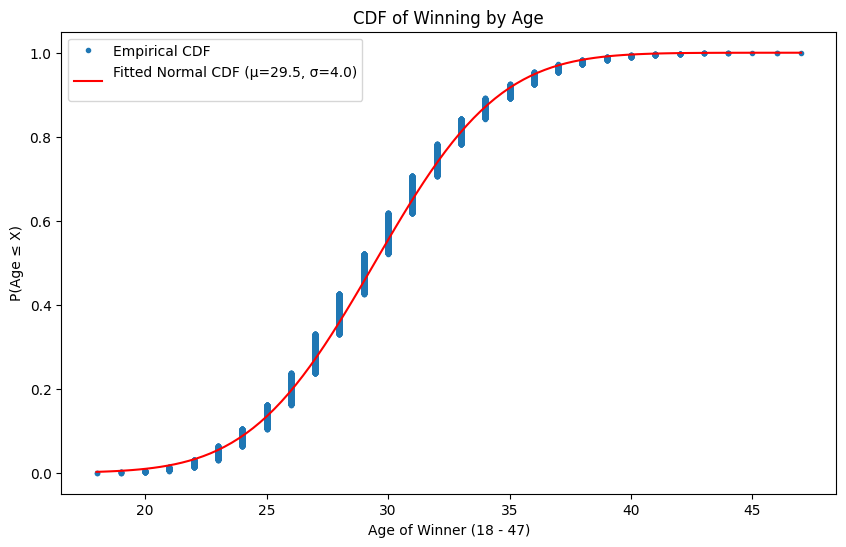

In [16]:
# copy fights so any manipulations are localized
fights = df.copy()

# get age for every winner of a fight
winners_age = []
for _, row in fights.iterrows():
    # check if f1 or f2 won
    if row['winner'] == row['f1_name']:
        winners_age.append(row['f1_age'])
    elif row['winner'] == row['f2_name']:
        winners_age.append(row['f2_age'])

# convert into df for better manipulation
win_ages = pd.DataFrame(winners_age, columns=['age'])

# sort ages and remove nonexistant data (fighters pre 2000 sometimes don't have their ages recorded)
sorted_ages = np.sort(win_ages['age'].dropna())

# normalize the data
mu, sigma = stats.norm.fit(win_ages['age'].dropna())

# get points for cdf
x = np.linspace(min(sorted_ages), max(sorted_ages), 100)
y = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages)

# get CFG
cdf_fitted = stats.norm.cdf(x, mu, sigma)

# plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_ages, y, marker='.', linestyle='none', label='Empirical CDF')
plt.plot(x, cdf_fitted, 'r-', label=f'Fitted Normal CDF (μ={mu:.1f}, σ={sigma:.1f})\n')
plt.xlabel(f'Age of Winner ({int(sorted_ages[0])} - {int(sorted_ages[-1])})')
plt.ylabel('P(Age ≤ X)')
plt.title('CDF of Winning by Age')
plt.legend()
plt.show()